# Import Libraries

In [1]:
from __future__ import print_function, division, absolute_import
import os,time
import numpy as np
np.random.seed(1)
import math
import utils
from utils import Scoring
import matplotlib.pyplot as plt
from dataLoader import reshape_folds
from collections import Counter
import pandas as pd
import argparse

import torch
torch.cuda.empty_cache()
from torch.autograd import Variable
import time
import torch.nn as nn
from torch.backends import cudnn

# Hyper-parameters

In [2]:
feature = "mfcc_13"

df = pd.read_excel (r'../logs/pretrained.xlsx')
features = df["feature"].iloc[:]
index = [i for i, feat in enumerate(features) if(feat==feature)][0]

class paramClass():
    def __init__(self):
        self.epoch = df["epoch"][index]
        self.batch_size = df["batch_size"][index]
        self.inp = df["inp"][index]
        self.base_lr = df["base_lr"][index]
        self.max_lr = df["max_lr"][index]
        self.step_size = df["step_size"][index]
        self.checkpoint = '../logs/' + self.inp + "/checkpoints/"
param = paramClass()

# Import validation Data 

In [3]:
data_file = "../data/feature/train_val_npzs/" + param.inp + "_train_val_data.npz"
data = np.load(data_file)

x_val = data['x_val_mfcc']
y_val = data['y_val']
val_parts = data['val_parts']
val_wav_files = data['val_wav_files']

x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2], 1)

#--- Reshape the folds
_, [y_val] = reshape_folds([], [y_val])

from keras.utils import to_categorical
y_val = to_categorical(y_val, num_classes = 2)

# Load thepretrained model

In [4]:
from model import resnet_extractor, abn_classifier
nodes = [16, 32, 64, 128]
num_layers = 2
model_fe = resnet_extractor(1, None, param.inp, nodes, num_layers).cuda()
model_abn = abn_classifier(model_fe.out_features, 2, dropout = None).cuda()

e = param.epoch - 1
checkpoint_fe = param.checkpoint + str(e+1) + "_saved_fe_model.pth.tar"
model_fe.load_state_dict(torch.load(checkpoint_fe)["state_dict"])
checkpoint_abn = param.checkpoint + str(e+1) + "_saved_cls_model.pth.tar"
model_abn.load_state_dict(torch.load(checkpoint_abn)["state_dict"])

epoch_loss = torch.load(checkpoint_fe)["loss"]
val_loss_load = torch.load(checkpoint_fe)["val_loss"]

loss_fn = nn.CrossEntropyLoss()

# Start Validation

In [5]:
print("EPOCH ---- ( " + str(e+1) + " )----")

model_fe.eval()
model_abn.eval()

with torch.no_grad():
    cls_pred = None
    cls_val = None
    total_features = np.array([])
    epoch_val_loss = 0
    s = 0
    for i, part in enumerate(val_parts):
        x,y = torch.from_numpy(x_val[s:s+part]),torch.from_numpy(y_val[s:s+part])
        s = s + part
        
        if(len(x) == 0): # If no bits are found
            continue
        
        x,y = Variable(x),Variable(y)
        x = x.type(torch.FloatTensor).cuda()
        
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        y = torch.tensor(np.array(y).reshape(-1, 2)).cuda().float()
        
        features = model_fe(x)
        cls = model_abn(features)
        
        val_loss = loss_fn(cls, torch.argmax(y,dim=1))
        
        if(i==0): total_features = features.cpu().numpy()
        else: total_features = np.concatenate((total_features, features.cpu().numpy()))

        if(cls_pred is None):
            cls_pred = cls
            cls_val = y
        else:
            cls_pred = torch.cat((cls_pred,cls))
            cls_val = torch.cat((cls_val,y))
        
        epoch_val_loss = epoch_val_loss + val_loss

    epoch_val_loss = epoch_val_loss/len(val_parts)

    print("Validation loss - ", str(epoch_val_loss.item()))

domain = np.asarray(val_wav_files).reshape((-1, 1))
score_log = Scoring(e + 1)
score, true, pred, subset = score_log.log_score(cls_pred, cls_val, val_parts, 
        y_domain = domain, list_out=True)

EPOCH ---- ( 82 )----
Validation loss -  0.507643461227417
TN: 113 FP: 33 FN: 14 TP: 124
Sensitivity: 0.899 Specificity: 0.774 Precision: 0.790 F1: 0.841 MACC 0.836 Accuracy 0.835


# Domain-wise Validation Result

In [6]:
tpn = true == pred
avg = 0
accu = []
log = []
log.append(score[:7])
for dataset in np.unique(subset):
    mask = subset == dataset
    true_sub = true[mask].reshape((-1, 1))
    pred_sub = pred[mask].reshape((-1, 1))
    sub = subset[mask].reshape((-1, 1))
    score = score_log.log_score(pred_sub, true_sub, y_domain = dataset, list_out=True)
    log.append(score[:7])

avg = ["avg"]
std = ["Std"]
for l in range(1, len(log[0])):
    s = []
    for lo in log:
        if(lo[0] == "Overall"): continue
        s.append(lo[l])
    avg.append(np.array(s).mean())
    std.append(np.array(s).std())

rows = [log[0], log[1],log[2],log[3],log[4],log[5], avg, std]

df = pd.DataFrame(rows, columns=["domain", "Macc", "precision", "sensitivity", \
                                 "specificity", "F1", "accuracy"])
print(df)

    domain      Macc  precision  sensitivity  specificity        F1  accuracy
0  Overall  0.836262   0.789809     0.898551     0.773973  0.840678  0.834507
1        a  0.737500   0.666667     0.950000     0.525000  0.783505  0.737500
2        b  0.765306   0.770833     0.755102     0.775510  0.762887  0.765306
3        c  0.833333   0.800000     1.000000     0.666667  0.888889  0.857143
4        d  0.800000   0.714286     1.000000     0.600000  0.833333  0.800000
5        e  1.000000   1.000000     1.000000     1.000000  1.000000  1.000000
6      avg  0.827228   0.790357     0.941020     0.713435  0.853723  0.831990
7      Std  0.092211   0.114464     0.094955     0.165249  0.085125  0.093014


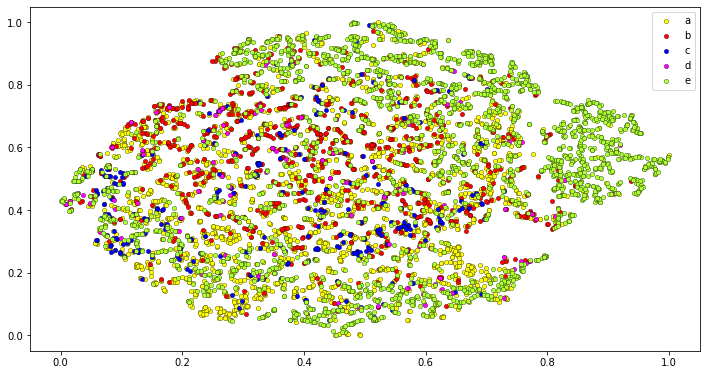

In [7]:
from sklearn.manifold import TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(total_features)

def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

#---- Domain wise TSNE
fig = plt.figure(figsize=(12, 6.33))
ax = fig.add_subplot(111)

colors_per_dom = ["Yellow", "Red", "Blue", "Magenta", "Greenyellow"]
for i, dom in enumerate(np.unique(val_wav_files)):
    indices = [i for i, l in enumerate(val_wav_files) if l == dom]

    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    ax.scatter(current_tx, current_ty, c=colors_per_dom[i], label= dom, edgecolors='Black',linewidths=0.3, s=20)

ax.legend(loc='best')
plt.show()
